In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import essay_analysis as ea
import re
from string import punctuation
from collections import OrderedDict, defaultdict, Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, RegexpStemmer
from sklearn.decomposition import NMF, PCA, LatentDirichletAllocation
from scipy.spatial.distance import pdist, squareform, cosine, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.misc import comb
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import seaborn as sns
import cPickle as pickle
from scipy.stats import ttest_ind
from itertools import combinations
from scipy.stats.stats import pearsonr
import networkx as nx
import json
import mpld3
import visualize as v
%matplotlib inline

In [2]:
df = pd.read_csv('../data/master_essay.csv', low_memory=False)

In [3]:
df[df['essay_final'].notnull()]['top_school_final'].value_counts()

0    2126
1    1051
Name: top_school_final, dtype: int64

In [4]:
df2 = df[df['essay_final'].notnull()].copy()

In [5]:
essays = df2['essay_final'].values.copy()
essays_idx = df2['id'].values
X = essays.copy()
y = df2['top_school_final'].values

### Stop Words & Stemming/Lemmatizing

1. Let's remove ASCII characters to avoid UnicodeDecodeErrors later.
2. We should remove stop words before stemming / lemmatizing (e.g. PorterStemmer turns 'was' into 'wa')
3. Stemming is better than Lemmatizing in our case, because we don't really need to preserve contextual meanings - it's more important that we group words that mean the same thing even if they take different forms. For instance, using a PorterStemmer, if we stem 'familial' and 'family', we get the 'famili' root word in both cases. However, with a WordNetLemmatizer, the output is distinct - it returns 'familial' and 'family'. Since we will eventually build a tfidf matrix, it is preferable to use a PorterStemmer here.

In [6]:
reload(ea)
ae = ea.AnalyzeEssays()

In [7]:
ae.stopWordsAndStem(X)

essay_analysis.py:170: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  essay = ' '.join([word for word in essay.split() if word not in self.stop_words])
/Users/MikeYung/anaconda/lib/python2.7/site-packages/nltk/stem/porter.py:274: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if word[-1] == 's':


### Transform Essays into TFIDF Matrix

In [8]:
# essays[10]

In [9]:
vec = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=10000)
mat = vec.fit_transform(X)

In [10]:
mat

<3177x10000 sparse matrix of type '<type 'numpy.float64'>'
	with 582653 stored elements in Compressed Sparse Row format>

### Visualize TFIDF against Acceptance (using PCA)

Goal: reduce the dimensions from 27k to 2, and visualize in a scatter plot.

In [10]:
pca = PCA(n_components=2)
pca.fit(mat.toarray())
mat_pca = pca.transform(mat.toarray())

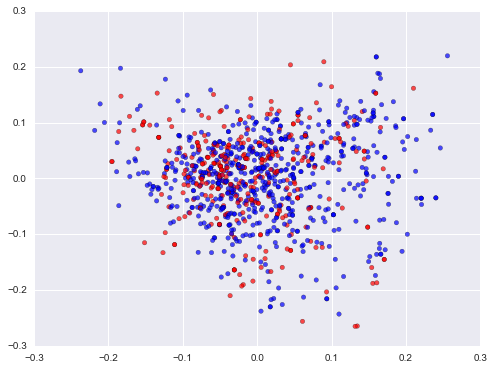

In [13]:
rand_idx = np.random.randint(0, len(X), 1000)
plt.figure(figsize=(8,6))
plt.scatter(mat_pca[rand_idx,0], mat_pca[rand_idx,1], alpha=0.7, s=20, c=y[rand_idx], cmap='bwr')

Not much to see here...

### Visualize using TSNE (t-Distributed Stochastic Neighbor Embedding)

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html <br>
Author recommends performing an inital round of dimensionality reduction first before doing TSNE. In our case, we will will NMF to reduce the data to 10 components first.

In [14]:
dr = ea.dimReduction()
mat_tsne = dr.getTSNE(NMF, 10, mat)

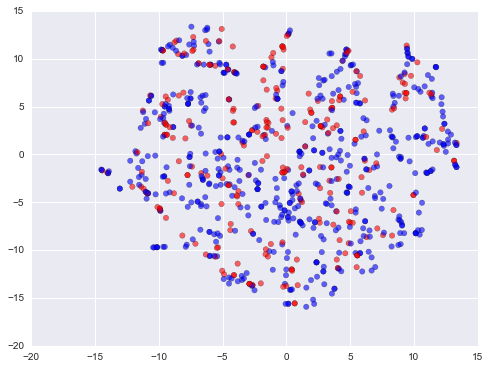

In [15]:
rand_idx = np.random.randint(0, len(X), 800)
plt.figure(figsize=(8,6))
plt.scatter(mat_tsne[rand_idx,0], mat_tsne[rand_idx,1], alpha=0.6, s=30, c=y[rand_idx], cmap='bwr')

Not much here either...

##### If time permits, try TruncatedSVD

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

### Non-Negative Matrix Factorization (NMF)

Chose this over SVD to preserve the interpretability of positive values.

Goal: identify latent features / hidden topics across the essays. May be able to use these as features in our predictive model. We can also compute a cosine similarity matrix: the idea is so we can show most 'similar' essays.

In [11]:
reload(ea)
tm = ea.TopicModeling()

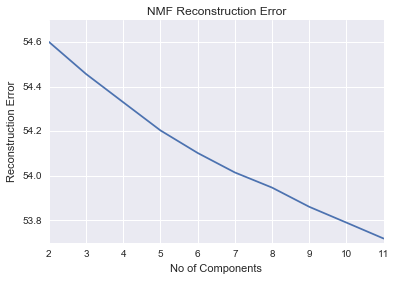

In [12]:
tm.plotOptimalNMF(mat, 12)

Doesn't look like there's any significant 'elbow' in the reconstruction error graph in the first 11 components. Any more than that and we'll likely lose the ability to 'bin'/categorize topics with similar semantic meaning.

After examining the various 'topics' generated from 2-10 topics, we heuristically decide that 7 is the best number. Let's take a look at the key words that represent each of these 7 topics.

In [14]:
nmf = NMF(n_components=7, random_state=100)
nmf.fit(mat)
H = nmf.components_
tm.showTopWords(H, vec, no_words=40)

[array([u'mother', u'father', u'famili', u'parent', u'mom', u'dad', u'life',
        u'brother', u'work', u'sister', u'home', u'live', u'family',
        u'help', u'time', u'day', u'grandmoth', u'care', u'alway', u'want',
        u'cancer', u'dream', u'hous', u'hard', u'children', u'hospit',
        u'job', u'make', u'becam', u'year', u'love', u'sibl', u'age',
        u'support', u'doctor', u'old', u'know', u'child', u'everyth',
        u'money'], 
       dtype='<U17'),
 array([u'music', u'play', u'piano', u'perform', u'song', u'band', u'danc',
        u'note', u'sing', u'stage', u'concert', u'orchestra', u'sound',
        u'guitar', u'jazz', u'piec', u'instrument', u'art', u'listen',
        u'chord', u'emot', u'musician', u'room', u'practic', u'audienc',
        u'content', u'love', u'theater', u'passion', u'feel', u'express',
        u'classic', u'audit', u'performance', u'melodi', u'violin',
        u'choir', u'everi', u'artist', u'piece'], 
       dtype='<U17'),
 array([u'cultur',

Let's now transform our tfidf matrix to get the low-dimensional (7-topic) version of it.

In [15]:
W = nmf.transform(mat)

##### Modeling Tests

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

In [128]:
def test(X,y,model,params):
    gs = GridSearchCV(model, param_grid=params, cv=5)
    gs.fit(X,y)
    print gs.grid_scores_
    y_pred = gs.predict(X)
    print confusion_matrix(y, y_pred)
    print gs.score(X,y)

In [129]:
test(W,y,RandomForestClassifier(), params = {'max_features':[2,3]})

[mean: 0.65313, std: 0.01004, params: {'max_features': 2}, mean: 0.63991, std: 0.00525, params: {'max_features': 3}]
[[2121    5]
 [  73  978]]
0.975448536355


In [131]:
test(W,y,KNeighborsClassifier(), params = {'n_neighbors':range(2,8)})

[mean: 0.64621, std: 0.01103, params: {'n_neighbors': 2}, mean: 0.60875, std: 0.01577, params: {'n_neighbors': 3}, mean: 0.65030, std: 0.01550, params: {'n_neighbors': 4}, mean: 0.63488, std: 0.01887, params: {'n_neighbors': 5}, mean: 0.65628, std: 0.01942, params: {'n_neighbors': 6}, mean: 0.63802, std: 0.02095, params: {'n_neighbors': 7}]
[[2022  104]
 [ 747  304]]
0.732137236387


### Pickle Tfidf-Vectorizer and NMF model

In [523]:
with open('../data/app/vectorizer.pkl', 'w') as f:
    pickle.dump(vec, f)
with open('../data/app/nmf.pkl', 'w') as f:
    pickle.dump(nmf, f)

### Export data (containing just essays + topics)

To make things easier when creating an app to recommend similar essays/profiles later on, let's create a new DataFrame containing just essays, topics, and userid.

In [16]:
essays_and_topics = np.hstack((essays_idx.reshape(-1,1), (essays.reshape(-1,1))))
essays_and_topics = np.hstack((essays_and_topics, W))
df_et_cols = ['id','content','family', 'music', 'culture', 'sport', 'personal', 'science', 'career']
df_et = pd.DataFrame(essays_and_topics, columns=df_et_cols)

In [17]:
df_et.head()

id                                            content      family  \
0  7668  The Art of Living in a Boy House\nStill sleepy...   0.0286212   
1  7666  Making a Leader\nThe auditorium is filling up....   0.0279414   
2  6342  Second nature now kicked in. As I bounced the ...    0.021991   
3  7565  I squeezed my arms tighter around my chest as ...           0   
4  7558  Growing up in a small, insignificant suburb in...  0.00830832   

        music   culture       sport   personal     science       career  
0   0.0126327         0   0.0171051  0.0398075   0.0461729  0.000983955  
1           0         0   0.0103799  0.0790994           0    0.0733329  
2   0.0100422   0.02812    0.146277          0  0.00519798   0.00527239  
3   0.0834848         0  0.00334936   0.078574           0            0  
4  0.00269371  0.105175  0.00553663  0.0280607           0            0

In [168]:
df_et['id'].astype(int).describe()

count      3177.000000
mean      64952.482216
std       59199.651561
min        6342.000000
25%       24725.000000
50%       49304.000000
75%       68479.000000
max      238095.000000
Name: id, dtype: float64

In [18]:
topics = df_et.columns[2:]

#### Create a % dataframe from df_et

In [19]:
df_et_p = df_et.copy()
for col in df_et.columns[2:]:
    df_et_p[col] = df_et[col]/df_et.ix[:,2:].sum(axis=1)

In [20]:
df_et_p.head()

id                                            content     family  \
0  7668  The Art of Living in a Boy House\nStill sleepy...   0.196948   
1  7666  Making a Leader\nThe auditorium is filling up....   0.146479   
2  6342  Second nature now kicked in. As I bounced the ...   0.101387   
3  7565  I squeezed my arms tighter around my chest as ...          0   
4  7558  Growing up in a small, insignificant suburb in...  0.0554722   

       music   culture      sport  personal    science      career  
0  0.0869284         0   0.117704  0.273923   0.317725  0.00677079  
1          0         0   0.054415  0.414668          0    0.384438  
2  0.0462988  0.129645   0.674396         0  0.0239648   0.0243079  
3    0.50472         0  0.0202491  0.475031          0           0  
4  0.0179851  0.702224  0.0369664  0.187353          0           0

#### Topics vs Schools

In [402]:
df_merged = pd.merge(df, df_et_p, how='inner', left_on='id', right_on='id')

In [22]:
df_merged_cols = df_et_cols[:]
df_merged_cols.append('top_school_final')

In [23]:
for t in topics:    
    print t
    accepts = df_merged[(df_merged['top_school_final']==1)][t]
    rejects = df_merged[(df_merged['top_school_final']==0)][t]
    print accepts.mean()
    print rejects.mean()
    print ttest_ind(accepts, rejects)

family
0.104296496293
0.118991065869
Ttest_indResult(statistic=-2.4363912375533352, pvalue=0.014889242343970221)
music
0.0758030363628
0.0647409385014
Ttest_indResult(statistic=1.9726334643073709, pvalue=0.048623969900588468)
culture
0.14253405632
0.128969974857
Ttest_indResult(statistic=2.067249444186043, pvalue=0.038791515606065058)
sport
0.103816305761
0.0943291483597
Ttest_indResult(statistic=1.4820752839555444, pvalue=0.13841950404948772)
personal
0.307105579349
0.285164499326
Ttest_indResult(statistic=2.5241583906787666, pvalue=0.011645941889761272)
science
0.138864364083
0.121088411281
Ttest_indResult(statistic=2.7855732404318396, pvalue=0.0053750270000469929)
career
0.127580161831
0.186715961806
Ttest_indResult(statistic=-8.4714314352056004, pvalue=3.6547489618556502e-17)


In [378]:
# tm.printAcceptanceByTopic(df_merged, low_thresh=0.03, mid_thresh=0.25)

In [24]:
topschools = df.columns[-27:-17].values

In [26]:
def printTopicsBySchool(df, school, thresh=0.5):
    subdf = df[df[school]==1][topics]
    print school.upper(), '({} admitted)'.format(len(subdf))
    for topic in topics:
        rate = len(subdf[subdf[topic]>thresh]) / float(len(subdf))
        print '{}% wrote about {}'.format(np.round(rate*100), topic)

In [27]:
def topicsBySchool(df, school, thresh=0.5):
    subdf = df[df[school]==1][topics]
    rates = []
    rates = map(lambda topic: len(subdf[subdf[topic]>thresh]) / float(len(subdf)) * 100 , topics)
    return rates

In [29]:
topics_by_topschool = map(lambda school: topicsBySchool(df_merged, school, thresh=0.25), topschools)
topschools_short = ['Harvard', 'Yale', 'Cornell', 'Columbia', 'UPenn', 'Princeton', 'Brown', 'Dartmouth', 'MIT', 'Stanford']
df_topschools = pd.DataFrame(topics_by_topschool, columns=topics, index=topschools_short)

family      music    culture      sport   personal    science  \
Harvard    19.736842   7.236842  23.026316  11.184211  51.315789  16.447368   
Yale       19.354839   7.258065  23.387097  10.483871  50.806452  19.354839   
Cornell    12.107623   8.520179  25.112108  16.591928  51.569507  21.076233   
Columbia   12.500000  10.156250  21.093750  12.500000  52.343750  25.000000   
UPenn      17.192982   9.473684  26.315789   9.473684  52.631579  15.087719   
Princeton  15.238095  12.380952  20.000000  14.285714  59.047619  15.238095   
Brown      20.143885  12.949640  24.460432   7.194245  62.589928  10.071942   
Dartmouth  18.269231  12.500000  20.192308  15.384615  49.038462  15.384615   
MIT        14.583333   8.333333  17.708333  13.541667  48.958333  27.083333   
Stanford   14.917127   8.287293  20.994475  14.364641  53.591160  22.099448   

              career  
Harvard    18.421053  
Yale       22.580645  
Cornell    21.076233  
Columbia   21.875000  
UPenn      17.543860  
Princeton  17.142857  
Brown      20.863309  
Dartmouth  19.230769  
MIT        18.750000  
Stanford   17.127072

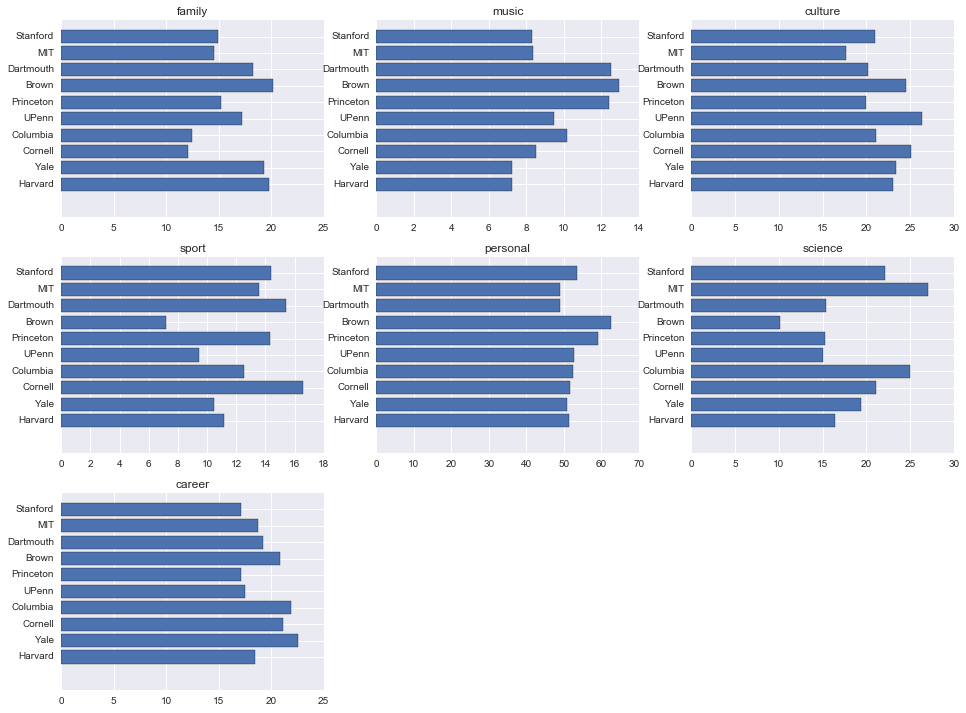

In [32]:
fig = plt.figure(figsize=(16,12))
for i,topic in enumerate(topics):
    plt.subplot(3,3,i+1)
    plt.barh(range(len(df_topschools)), df_topschools[topic], tick_label=df_topschools.index, align='center')
    plt.title(topic)

Couple observations:
- As expected, MIT was more likely than any school to write about Science.
- In general, students tended to write least about Sports and Music. In particular, just 7% of Brown students wrote about Sport, while just 7% of Harvard and Yale students wrote about Music.
- UPenn was more likely than any other school to write about culture, reflecting the vast international student body there.

#### ALL Schools

In [33]:
df_schools = pd.read_csv('../data/all_schools.csv', low_memory=False)
df_schools.drop('Unnamed: 0', axis=1, inplace=True)
df_et_schools = pd.merge(df_et, df_schools, left_on='id', right_on='id')

In [34]:
topics_by_school = map(lambda school: df_et_schools[df_et_schools[school]==1][topics].mean(), df_schools.columns)
df_et_schools_T = pd.DataFrame(topics_by_school , columns=topics, index=df_schools.columns)
df_et_schools_T.drop('id', inplace=True)

### Plot 2-D Representation of Topics

Let's find the best 'K' to color the scatterplot of the reduced 2-D representation we will be plotting.

In [168]:
reload(ea)
ct = ea.ClusterTools()
ct.findBestK(df_et_schools_T, max_k=2)

The best K is 2, with a silhouette score of 0.702143445114.


Even though k=2 has the highest silhouette score, let's see if we get visual separation with k=3.

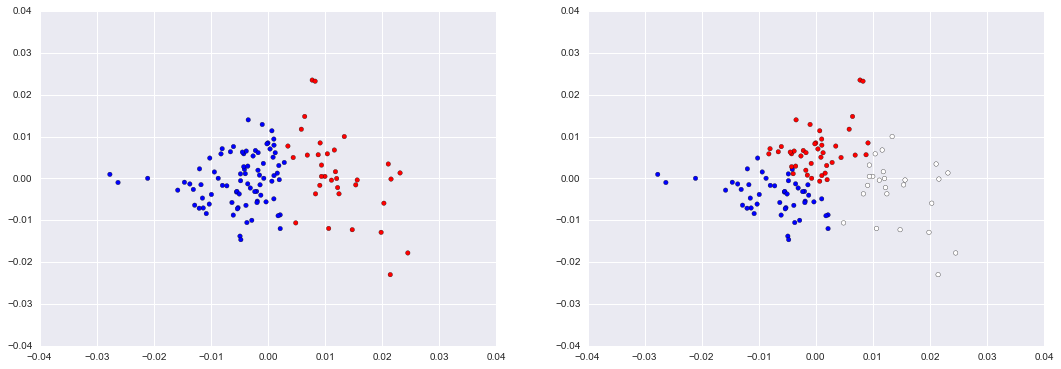

In [463]:
fig = plt.figure(figsize=(18,6))
for i,k in enumerate([2,3]):
    km = KMeans(n_clusters=k)
    km.fit(df_et_schools_T)
    pca = PCA(n_components=2)
    pca_schools = pca.fit_transform(df_et_schools_T)
    fig.add_subplot(1,2,i+1)
    plt.scatter(pca_schools[:,0], pca_schools[:,1], c=km.labels_, cmap='bwr')

In [497]:
topics

Index([u'family', u'music', u'culture', u'sport', u'personal', u'science',
       u'career'],
      dtype='object')

In [496]:
reload(v)
km = KMeans(n_clusters=6,random_state=123)
km.fit(pca_schools)
cluster_names = {0:'State Schools 1   ',1:'Ivy Leagues',2:'Mixed',3:'State Schools 2',4:'Science/Tech',
                 5:'Liberal Arts', 6:'na'}
colors = {}
v.plotEssays(pca_schools[:,0], pca_schools[:,1], km.labels_, all_schools, cluster_names)

In [377]:
v.showTopicCorr(df_et_schools_T, pca_schools, topics, 0.55)

PCA 0 is -0.954853250039 correlated with personal
PCA 0 is 0.722213765448 correlated with career
PCA 1 is -0.635832430278 correlated with culture
PCA 1 is 0.56050176544 correlated with sport
PCA 1 is 0.592598852868 correlated with science


In [528]:
essay_ex_idx = [9,10,12]
essays[12]

'Its a peculiar thing to be told youre offbeat. I love music. And when I listen to my favorite song, I feel as if Ive merged with the melody. The only problem is, Im not merged with the music at all. In fact, its often as if Im listening to an entirely different song. When I tap my foot or clap my hands, Im so offbeat that it becomes annoying to others listening.\nAs a child, my younger sister would joke about my dancing ability, or lack thereof.\nYoure a black girl, and you cant dance?! she would joke.\nDont worry, I would reply. You havent really seen me dance. I only do that with my friends.\nBut, we both knew that wasnt true. I couldnt dance. Not in front of her and certainly not in front of my friends.\nMy inability to groove became increasingly problematic as I grew older. I was never compared to African American stereotypes in elementary school. In middle school and forward, however, it seemed as if the ability to dance was integral to being African American.\nWhen I joined Jack

### Re-Graph for All Essays

In [257]:
pca_essays = pca.fit_transform(df_et.iloc[:,2:])
essay_labels_text = v.getTopicLabels(df_et.iloc[:,2:])
essay_labels_num = v.getTopicLabels(df_et.iloc[:,2:], type='num')

In [445]:
reload(v)
essay_labels_summary = v.getSummaries(df_et['content'].values)

In [491]:
reload(v)
essay_cluster_names = {i:val+'     ' for i,val in enumerate(topics)}
v.plotEssays(pca_essays[:,0], pca_essays[:,1], essay_labels_num, essay_labels_summary, essay_cluster_names, ms=4)

In [487]:
df_et['topic_cluster_text'] = essay_labels_text
df_et['topic_cluster_num'] = essay_labels_num
df_et['summary'] = essay_labels_summary

In [488]:
df_et['pca1'] = pca_essays[:,0]
df_et['pca2'] = pca_essays[:,1]

In [365]:
showTopicCorr(df_et, pca_essays)

PCA 0 is 0.824207617235 correlated with personal
PCA 0 is -0.777538624165 correlated with career
PCA 1 is 0.544422722187 correlated with culture
PCA 1 is -0.886125571474 correlated with sport


In [493]:
df_et.to_csv('../data/app/essays_and_topics.csv')

### Calculate Weights for Graph

In [43]:
all_schools = df_et_schools_T.index
combos = list(combinations(all_schools, 2))

In [51]:
school_dist = pairwise_distances(df_et_schools_T.iloc[:,:-1])
school_dict = {school:i for i,school in enumerate(all_schools)}
school_weights = []
for s1, s2 in combos:
    school_weights.append((s1, s2, school_dist[school_dict[s1]][school_dict[s2]]))

In [52]:
df_graph = pd.DataFrame(school_weights, columns=['s1','s2','weight'])
df_graph.head()

s1  \
0  University of Connecticut (Storrs, CT)_final   
1  University of Connecticut (Storrs, CT)_final   
2  University of Connecticut (Storrs, CT)_final   
3  University of Connecticut (Storrs, CT)_final   
4  University of Connecticut (Storrs, CT)_final   

                                                  s2    weight  
0  Carnegie Mellon University (Pittsburgh, PA)_final  0.025472  
1  University of Massachusetts - Amherst (Amherst...  0.011117  
2  George Washington University (Washington, DC)_...  0.021273  
3          Williams College (Williamstown, MA)_final  0.019901  
4      University of Florida (Gainesville, FL)_final  0.025360

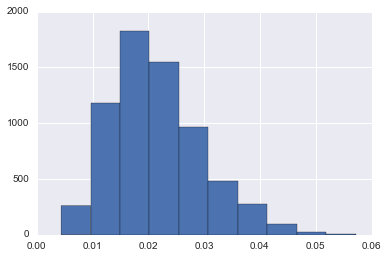

In [84]:
# _=plt.boxplot(df_graph['weight'])
df_graph['weight'].hist()

In [54]:
df_graph2 = df_graph[df_graph['weight']>0.03].copy()
len(df_graph2)

975

In [276]:
df_graph2.to_csv('../data/graph_weights.tsv',sep='\t')

In [77]:
links = []
for s1,s2,weight in school_weights:
    if weight > 0.04:
        temp_dict = {'source':s1, 'target':s2, 'value':weight}
        links.append(temp_dict)

In [68]:
nodes = []
for school in all_schools:
    temp_dict = {'id': school, 'group': df_et_schools_T.loc[school,'cluster']}
    nodes.append(temp_dict)

In [79]:
json_output = {'nodes': nodes, 'links': links}
with open('../data/d3_weights.json', 'w') as f:
    json.dump(json_output, f)

#### Distribution of Topics

In [280]:
# _=pd.scatter_matrix(df_et_schools_T.astype(float), figsize=(15,12))

### Export Tfidf Matrix (for recommending essays)

In [518]:
with open('../data/app/tfidf_mat.pkl', 'w') as f:
    pickle.dump(mat, f)

### Experimenting with Latent Dirichlet Allocation (LDA)

In [253]:
count_vec = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=10000)
count_mat = count_vec.fit_transform(X)

In [254]:
count_mat

<3177x10000 sparse matrix of type '<type 'numpy.int64'>'
	with 582653 stored elements in Compressed Sparse Row format>

In [289]:
lda = LatentDirichletAllocation(n_topics=7, max_iter=50)
lda.fit(count_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=5, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [290]:
W_lda = lda.transform(count_mat)

In [291]:
H_lda = lda.components_
tm.showTopWords(H_lda, count_vec, 40)

[array([u'learn', u'world', u'cultur', u'differ', u'experi', u'research',
        u'new', u'student', u'scienc', u'american', u'school',
        u'understand', u'music', u'english', u'use', u'art', u'languag',
        u'studi', u'passion', u'creat', u'class', u'comput', u'program',
        u'thi', u'mani', u'allow', u'develop', u'design', u'speak', u'like',
        u'commun', u'question', u'engin', u'chines', u'knowledg', u'human',
        u'explor', u'peopl', u'work', u'idea'], 
       dtype='<U17'),
 array([u'world', u'like', u'time', u'life', u'day', u'feel', u'new',
        u'peopl', u'way', u'everi', u'make', u'place', u'know', u'book',
        u'read', u'look', u'want', u'im', u'love', u'home', u'ive',
        u'alway', u'stori', u'someth', u'live', u'think', u'year', u'thing',
        u'dont', u'write', u'mind', u'friend', u'water', u'littl', u'old',
        u'word', u'long', u'creat', u'thought', u'thi'], 
       dtype='<U17'),
 array([u'life', u'school', u'help', u'work', u'wa